# Project: Analysis of Seattle Bike Collison - part 2


## Organizing and cleaning data

In [215]:
#01.31.2019
#Ada Kim
#TDI-Q3-Part2

#importing basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
import csv
%matplotlib inline

#loading data from data.seattle.gov
seattle = pd.read_csv('seattle.csv', engine='c', low_memory=False)

#selecting target columns
df = seattle[['X', 'Y', 'ADDRTYPE','LOCATION', 'SEVERITYCODE', 'SEVERITYDESC', 'COLLISIONTYPE', 
             'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 
             'ROADCOND', 'LIGHTCOND', 'INCDATE', 'INCDTTM', 
             'JUNCTIONTYPE', 'ST_COLCODE', 'SPEEDING','WEATHER']]

#removing rows without lat/long information
df.dropna(subset=['X','Y'], inplace=True)
df.rename(columns={'X': 'LAT', 'Y': 'LONG'}, inplace=True)
geometry = [Point(xy) for xy in zip(df['LAT'], df['LONG'])]
df_map = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

## Which locations in the city should get paid more attention to prevent bike collisions?

### Number of bike collisions per year

From the previous exploratory analysis, we learned major locations of bike collision and its level of severity. Then I came up with another question: *Which locations should get paid more attention in order to prevent bike collision?* 

If there are some specific streets or areas are continously having bike collisions across the year, then those spots may need more attention for the maintenence. So, I decided to look into chronological influences. First, I wanted to check the number of bike collisions per year.

According to the graph, it seemed the number of bike collision peaked during the period 2013-2015 but then started to decrease. What kinds of events did happen during that period? To fully understand the trend, I probably should look into additional sources of data for further investigation; instead, I turned to monthly data because seasonal impact should be more repeatable. 

Basic statistics:


,N of collision
count,15.000000
mean,363.200000
std,56.370205
min,230.000000
25%,353.500000
50%,364.000000
75%,384.000000
max,469.000000


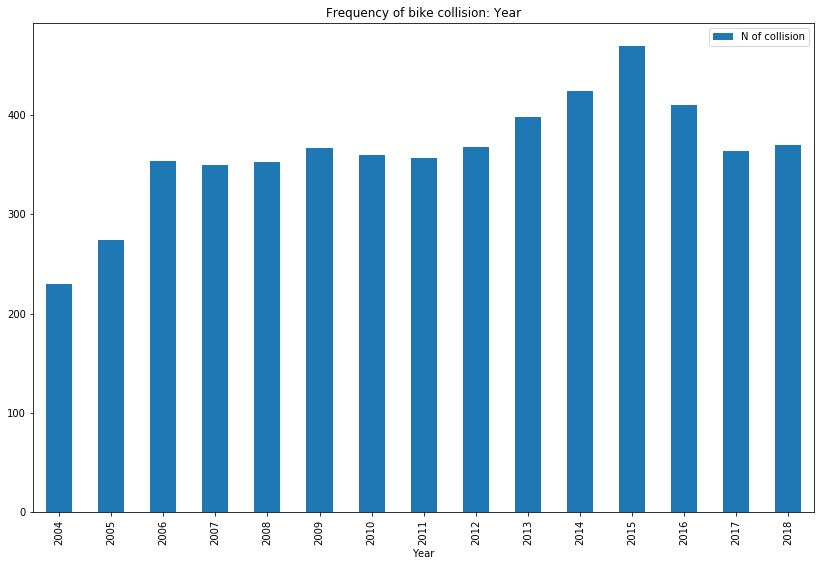

In [329]:
cycle_map = df_map[df_map['PEDCYLCOUNT'] >= 1][['INCDTTM','SEVERITYCODE','geometry']]
cycle_map['INCDTTM'] = cycle_map['INCDTTM'].apply(pd.to_datetime)
time = cycle_map['INCDTTM']

Y_count = pd.DataFrame(time.groupby([time.dt.year]).count())
Y_count.index.name = 'Year'
Y_count.columns = ['N of collision']
Y_count.plot(kind='bar', title = 'Frequency of bike collision: Year', figsize=(14,9), fontsize=10)

print('Basic statistics:')
display(Y_count.describe())

### Number of bike collisions per month 

I compared two seasons, summer and winter, in order to analyze monthly data, 

The number of bike collisions tends to increase from April, reaching its peak during July and August, then start to decrease. Would there be any visible differences in trends of bike collision between summer and winter season? 

Basic statistics:


,N of collision
count,12.000000
mean,454.000000
std,145.135673
min,259.000000
25%,324.000000
50%,464.000000
75%,591.500000
max,640.000000


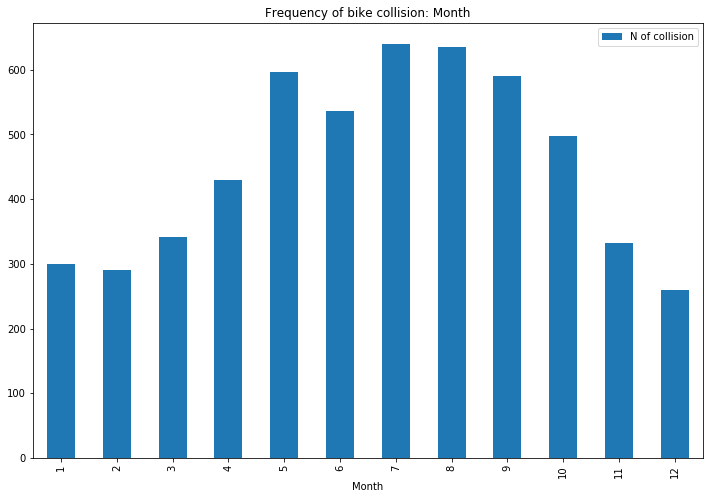

In [252]:
cycle_map = df_map[df_map['PEDCYLCOUNT'] >= 1][['INCDTTM','SEVERITYCODE','geometry']]
cycle_map['INCDTTM'] = cycle_map['INCDTTM'].apply(pd.to_datetime)
time = cycle_map['INCDTTM']

M_count = pd.DataFrame(time.groupby([time.dt.month]).count())
M_count.index.name = 'Month'
M_count.columns = ['N of collision']
M_count.plot(kind='bar', title = 'Frequency of bike collision: Month', figsize=(12,8), fontsize=10)

print('Basic statistics:')
display(M_count.describe())

In [282]:
Year = pd.DataFrame(cycle_map['INCDTTM'].dt.year)
Month = pd.DataFrame(cycle_map['INCDTTM'].dt.month)

new_map = cycle_map.merge(Year, left_index=True, right_index=True, how='left') #merge them together
new_map = new_map.merge(Month, left_index=True, right_index=True, how='left') #merge them together
new_map.columns = ['Date','SEVERITYCODE','geometry','Year','Month']

year_map = new_map[new_map['Year'] >= 2015]
summer_map = new_map[(new_map['Month'] >= 5) & (new_map['Month'] <= 9)]
winter_map = new_map[(new_map['Month'] == 1) | (new_map['Month'] == 2) 
                     | ((new_map['Month'] >= 10) & (new_map['Month'] <= 12))] 

## Bike collision during the summer season

Typically in the Pacific Northwest area, summer starts in late May and lasts until the end of September, which is the best season for outdoor activities. In the map, the colors of collision spots get "warmer" as the season gets hotter. Looking at the areas, a large rectangle of bike collision is surrounding the Lake Union, including major roads and bridges connecting north and south part of Seattle. 

Total count of collision:


2998

Total frequency of each category:


2     2433
1      326
2b     223
3       16
Name: SEVERITYCODE, dtype: int64

Percentage of each category:


2     0.811541
1     0.108739
2b    0.074383
3     0.005337
Name: SEVERITYCODE, dtype: float64

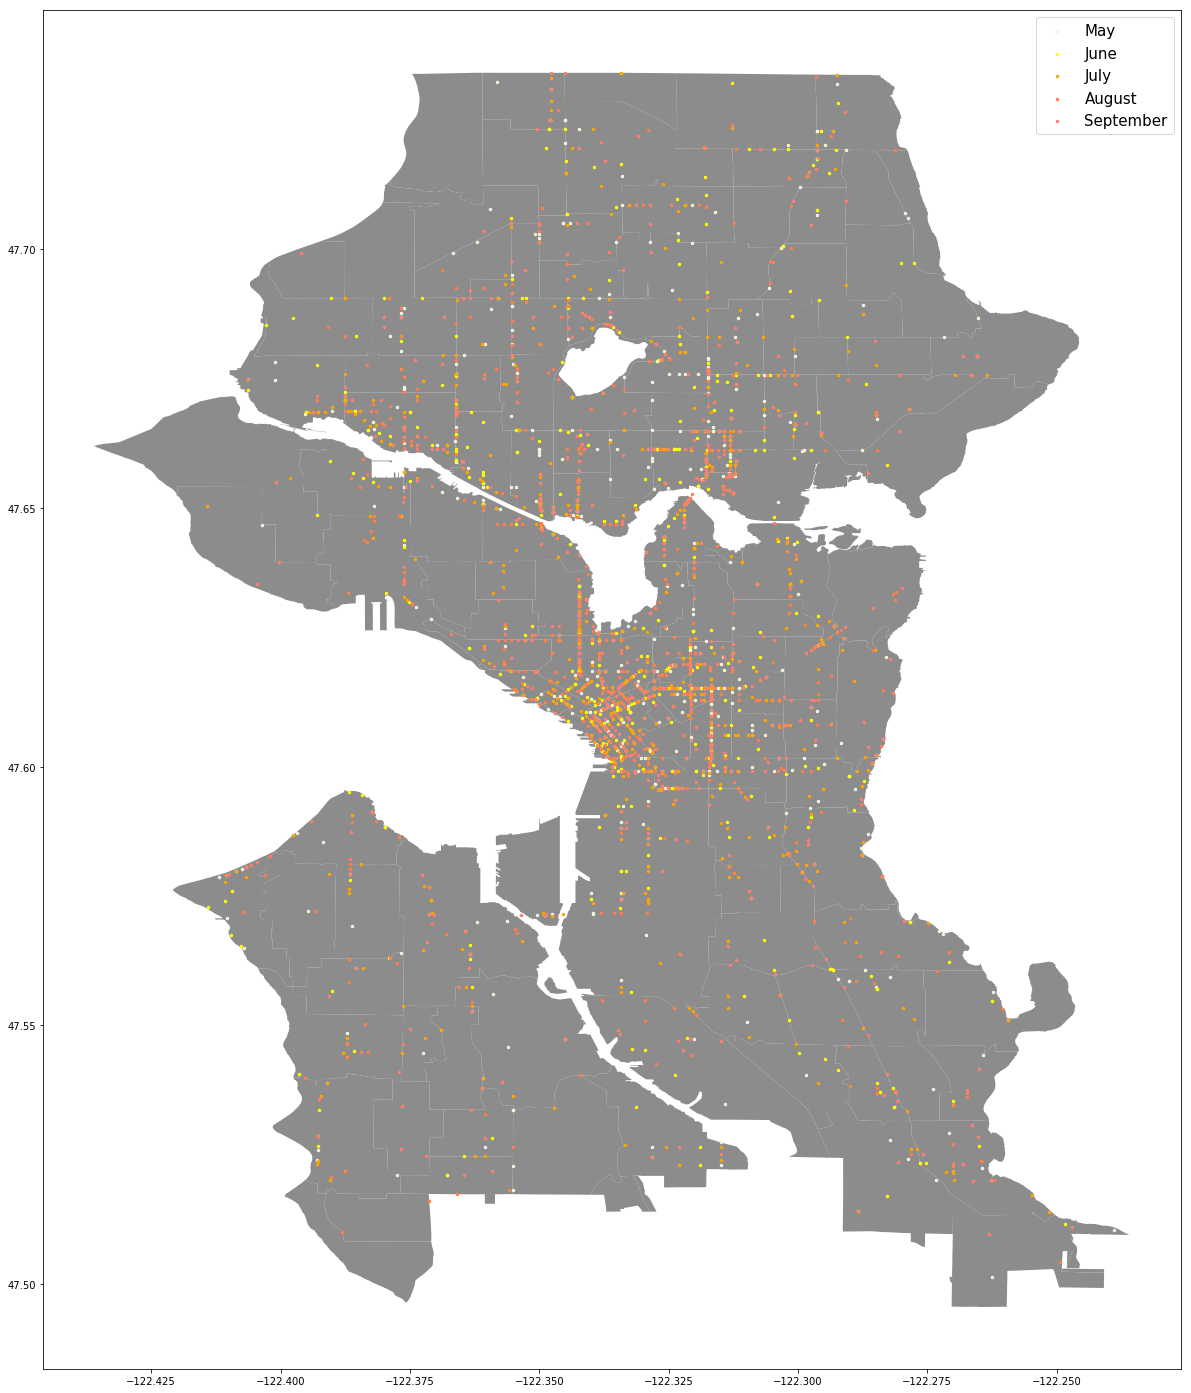

In [250]:
cycle_map = df_map[df_map['PEDCYLCOUNT'] >= 1][['SEVERITYCODE','geometry']]

#plotting Seattle map
seattle_map = gpd.read_file('2010_US_Census_Tracts/2010_US_Census_Tracts.shp') 

#overlaying major traffic flow count from 2011
#traffic_map = gpd.read_file('2011_Traffic_Flow_Counts/2011_Traffic_Flow_Counts.shp')
fig, ax = plt.subplots(figsize = (25, 25))

seattle_map.plot(ax=ax, alpha=0.9, color='grey')
#traffic_map.plot(ax=ax, alpha=0.4, color='grey')

#plotting season data
summer_map[summer_map['Month'] == 5].plot(ax=ax, markersize=6, color='beige', marker='o', label='May')
summer_map[summer_map['Month'] == 6].plot(ax=ax, markersize=6, color='yellow', marker='o', label='June')
summer_map[summer_map['Month'] == 7].plot(ax=ax, markersize=6, color='orange', marker='o', label='July')
summer_map[summer_map['Month'] == 8].plot(ax=ax, markersize=6, color='coral', marker='o', label='August')
summer_map[summer_map['Month'] == 9].plot(ax=ax, markersize=6, color='salmon', marker='o', label='September')
plt.legend(prop={'size': 15})

#calculating percentage of each severity code for reference

print('Total count of collision:')
display(summer_map['SEVERITYCODE'].count())

print('Total frequency of each category:')
display(summer_map['SEVERITYCODE'].value_counts())

print('Percentage of each category:')
display(summer_map['SEVERITYCODE'].value_counts(normalize=True))

## Bike collision during the winter (or rainy) season

Winter season starts with rain; from mid-October to February. During this period, the collision rate dropped down to 55% of the summer season, which may be related to the amount of bike traffic. 

While most collisions occurred on the major connections across the city during the summer, collision spots in winter seem to be more scattered and the visual patterns are also slightly different. Yet some of the locations are not much differentiated by the season, including streets near campus, SLU, and some of residential areas like Phinney Ridge or Lake City.

Total count of collision:


1678

Total frequency of each category:


2     1358
1      211
2b     104
3        5
Name: SEVERITYCODE, dtype: int64

Percentage of each category:


2     0.809297
1     0.125745
2b    0.061979
3     0.002980
Name: SEVERITYCODE, dtype: float64

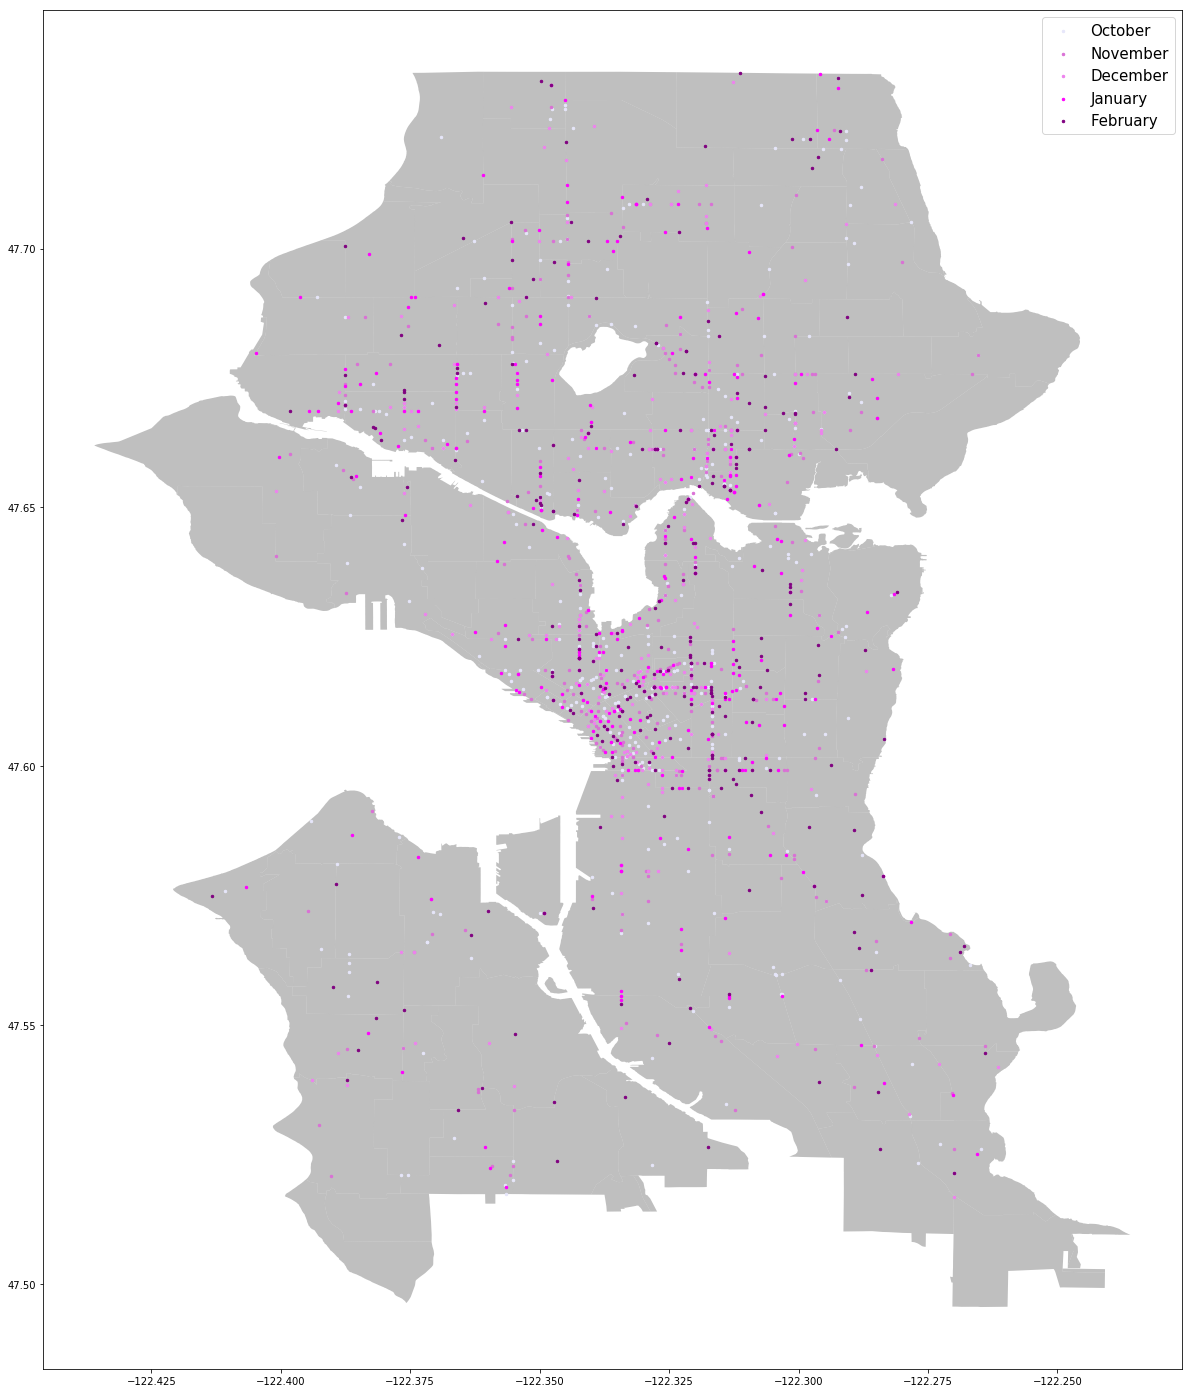

In [309]:
#plotting Seattle map
seattle_map = gpd.read_file('2010_US_Census_Tracts/2010_US_Census_Tracts.shp') 
#overlaying major traffic flow count from 2011
#traffic_map = gpd.read_file('2011_Traffic_Flow_Counts/2011_Traffic_Flow_Counts.shp')
fig, ax = plt.subplots(figsize = (25, 25))

seattle_map.plot(ax=ax, alpha=0.5, color='grey')
#traffic_map.plot(ax=ax, alpha=0.4, color='grey')

#plotting season data
winter_map[winter_map['Month'] == 10].plot(ax=ax, markersize=6, color='lavender', marker='o', label='October')
winter_map[winter_map['Month'] == 11].plot(ax=ax, markersize=6, color='orchid', marker='o', label='November')
winter_map[winter_map['Month'] == 12].plot(ax=ax, markersize=6, color='violet', marker='o', label='December')
winter_map[winter_map['Month'] == 1].plot(ax=ax, markersize=6, color='magenta', marker='o', label='January')
winter_map[winter_map['Month'] == 2].plot(ax=ax, markersize=6, color='purple', marker='o', label='February')
plt.legend(prop={'size': 15})

#calculating percentage of each severity code for reference

print('Total count of collision:')
display(winter_map['SEVERITYCODE'].count())

print('Total frequency of each category:')
display(winter_map['SEVERITYCODE'].value_counts())

print('Percentage of each category:')
display(winter_map['SEVERITYCODE'].value_counts(normalize=True))

## Additional analysis of weather impact on bike collision

Just wanted to double-check the impact of weather. One interesting point is that a few roads reveal visible number of bike collisions especially on cloudy days (red dots), however, there is not enough evidence to describe "why."

Clear or Partly Cloudy          3220
Overcast                         635
Raining                          464
Unknown                           73
Fog/Smog/Smoke                     4
Other                              3
Blowing Sand or Dirt or Snow       1
Snowing                            1
Name: WEATHER, dtype: int64

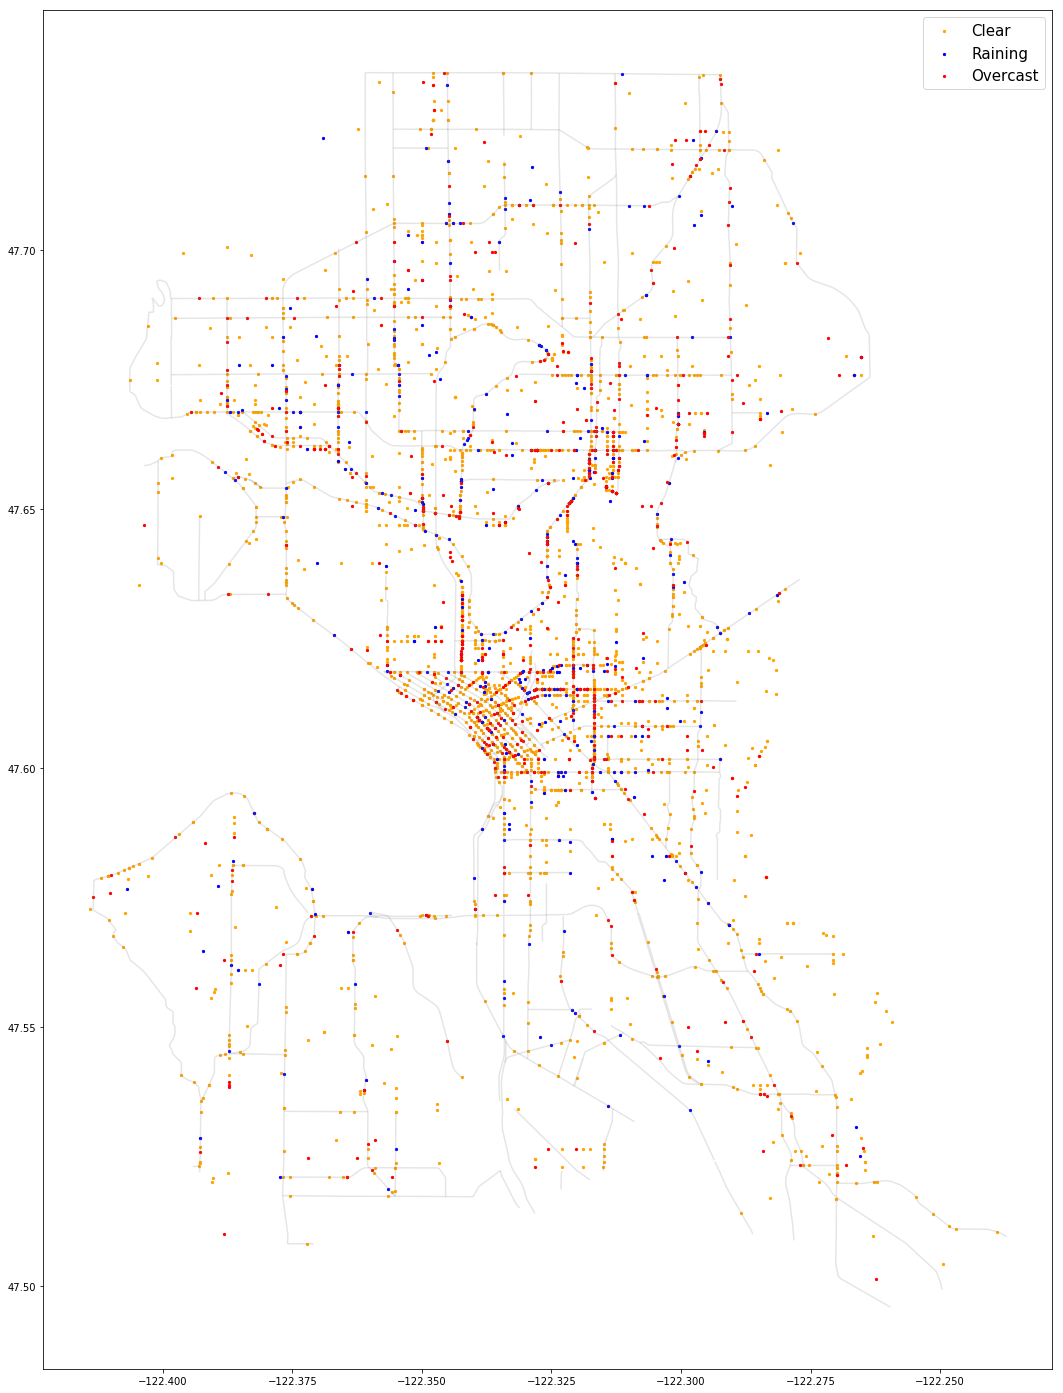

In [326]:
cycle_map = df_map[df_map['PEDCYLCOUNT'] >= 1][df_map['SEVERITYCODE'] == '2'][['WEATHER','geometry']]

#plotting Seattle map
seattle_map = gpd.read_file('2011_Traffic_Flow_Counts/2011_Traffic_Flow_Counts.shp') 
#seattle_map = gpd.read_file('2010_US_Census_Tracts/2010_US_Census_Tracts.shp') 
#seattle_map = gpd.read_file('City_of_Seattle_Shoreline/City_of_Seattle_Shoreline.shp') 
fig, ax = plt.subplots(figsize = (25, 25))
seattle_map.plot(ax=ax, alpha=0.2, color='grey')

# #plotting severity data
cycle_map[cycle_map['WEATHER'] == 'Clear or Partly Cloudy'].plot(ax=ax, markersize=5, color='orange', marker='o', label='Clear')
cycle_map[cycle_map['WEATHER'] == 'Raining'].plot(ax=ax, markersize=5, color='blue', marker='o', label='Raining')
cycle_map[cycle_map['WEATHER'] == 'Overcast'].plot(ax=ax, markersize=5, color='red', marker='o', label='Overcast')
plt.legend(prop={'size': 15})

cycle_map['WEATHER'].value_counts()

## Conclusion

The comparison between the two maps reveals the locations of "core" roads and lanes used not only seasonally but constantly for Seattleite's bike riding. For example, I noticed bike collisions on Burke-Gilman Trail, upper edges of straits from Ballard to Fremont, has been visibly reduced during the winter, unlike my impression; perhaps the trail has been mainly used for seasonal activities rather than commuting.

This is the end of the exploratory analysis, yet it should be interesting to investigate whether the seasonal effect differs from each year, relating to major construction events occurred in a specific period.

Another interesting future work should be comparing collision spots to the actual geography of the area. For example, hills (Seattle is famous for its hilly-ness) or blind spots may increase the number of bike collisions, which cannot be detected from the current map.  

Findings of this project provides a good piece of information to support important decision making on building, constructing, and maintaining bike roads and lanes across the city. I hope my project contributes to improving welfare and safety of bikers in Seattle, the most bike-friendly city in the US!